## This notebook is used to calculate log2-fold changes in OTUs and creates Figure 5 and Supplemental Figures 19 and 20 and Supplemental Table 7.

In [2]:
# Loading required packages
library(plyr)
library(dplyr)
library(reshape)
library(ggplot2)
library(phyloseq)
library(metagenomeSeq)
library(biomformat)
library(interactiveDisplay)
library(wesanderson)

### Can start here with phyloseq file

In [5]:
# Import dataset
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")
ps
# Normalize it for later reference
ps.norm = transform_sample_counts(ps, function(x) x/sum(x))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5938 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 5938 taxa by 16 taxonomic ranks ]

In [6]:
ps.biom = ps
# Copy phyloseq object
biom = make_biom(data = t(otu_table(ps.biom)), observation_metadata= tax_table(ps.biom), sample_metadata = sample_data(ps.biom))
# turn phyloseq into a biom table with OTU table, taxonomy, and sample data
biom.MRexp = biom2MRexperiment(biom)
# turns our biom file into the type of file needed for this analysis (an MRexperiment object)
biom.MRexp = biom.MRexp[,-which(is.na(pData(biom.MRexp)$pH))]
biom.MRexp

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

MRexperiment (storageMode: environment)
assayData: 5938 features, 94 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: 15S-NT-19O 15S-NT-21O ... 15S-WB-U05O (94 total)
  varLabels: Barcodes Sample_ID ... Soil_Class (103 total)
  varMetadata: labelDescription
featureData
  featureNames: sq1 sq2 ... sq6383 (5938 total)
  fvarLabels: Kingdom Phylum ... Citation.Source (16 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [7]:
#Preparing object for metegenomeseq analysis
MRexp = biom.MRexp 
MRexp = cumNorm(MRexp, cumNormStat(MRexp, qFlag=TRUE, pFlag = FALSE))
ModelData = pData(MRexp)
# Setting factors to be proper values
ModelData$pH = as.numeric(ModelData$pH)
ModelData$TC_pct = as.numeric(ModelData$TC_pct)
ModelData$Veg_Comm = make.names(ModelData$Veg_Comm)
ModelData$Burned_Unburned = as.factor(ModelData$Burned_Unburned)
ModelData$Burned_Unburned = ordered(ModelData$Burned_Unburned, levels = c('Unburned','Burned'))
# Establishing model formula
model = model.matrix(~Veg_Comm+TC_pct+pH+Burned_Unburned, data=ModelData)
# Assigning settings
settings = zigControl(tol = 1e-04, maxit = 30, verbose = TRUE, dfMethod = "default", pvalMethod = "default")
# Running fit
fit = fitZig(obj=MRexp, mod=model, control = settings, useCSSoffset = TRUE, zeroMod = NULL, useMixedModel = FALSE)

Default value being used.


it= 0, nll=125.06, log10(eps+1)=Inf, stillActive=5938
it= 1, nll=118.54, log10(eps+1)=Inf, stillActive=4941
it= 2, nll=116.33, log10(eps+1)=Inf, stillActive=3323
it= 3, nll=119.87, log10(eps+1)=Inf, stillActive=1822
it= 4, nll=120.32, log10(eps+1)=Inf, stillActive=1191
it= 5, nll=120.44, log10(eps+1)=Inf, stillActive=847
it= 6, nll=121.43, log10(eps+1)=Inf, stillActive=499
it= 7, nll=122.23, log10(eps+1)=Inf, stillActive=298
it= 8, nll=122.75, log10(eps+1)=Inf, stillActive=207
it= 9, nll=122.89, log10(eps+1)=Inf, stillActive=182
it=10, nll=122.93, log10(eps+1)=Inf, stillActive=174
it=11, nll=122.99, log10(eps+1)=Inf, stillActive=159
it=12, nll=123.03, log10(eps+1)=Inf, stillActive=152
it=13, nll=123.05, log10(eps+1)=Inf, stillActive=151
it=14, nll=123.07, log10(eps+1)=Inf, stillActive=149
it=15, nll=123.08, log10(eps+1)=Inf, stillActive=148
it=16, nll=123.09, log10(eps+1)=Inf, stillActive=148
it=17, nll=123.09, log10(eps+1)=Inf, stillActive=147
it=18, nll=123.09, log10(eps+1)=Inf, stil

In [8]:
EffSamp = calculateEffectiveSamples(fit)
MeanEffSamp = mean(EffSamp[!is.na(EffSamp)])
# Effective sample size is calculated, and the average values of this is determined
rareFeatures = which(rowSums(MRcounts(MRexp) > 0) < MeanEffSamp)
# These are the taxa that that had less than the average number of effective samples
# As recommended in the vignette: https://www.bioconductor.org/packages/devel/bioc/vignettes/metagenomeSeq/inst/doc/metagenomeSeq.pdf
MRexp = MRexp[-rareFeatures, ]
# Take the data object and remove the rareFeatures (taxa)
# Re-run the analyses below.
MRexp = cumNorm(MRexp, cumNormStat(MRexp, qFlag=TRUE, pFlag = FALSE))
ModelData = pData(MRexp)

Default value being used.


In [9]:
# Resetting the model parameters
ModelData$pH = as.numeric(ModelData$pH)
ModelData$TC_pct = as.numeric(ModelData$TC_pct)
ModelData$Veg_Comm = make.names(ModelData$Veg_Comm)
ModelData$Burned_Unburned = as.factor(ModelData$Burned_Unburned)
ModelData$Burned_Unburned = ordered(ModelData$Burned_Unburned, levels = c('Unburned','Burned'))

model = model.matrix(~Veg_Comm+TC_pct+pH+Burned_Unburned, data=ModelData)
# Creating the model that we will use to analyze our data.
fit = fitZig(obj=MRexp, mod=model, control = settings, useCSSoffset = TRUE, zeroMod = NULL, useMixedModel = FALSE)
#Re-running the fit with the EffSamp - normalized data    

it= 0, nll=145.75, log10(eps+1)=Inf, stillActive=286
it= 1, nll=161.43, log10(eps+1)=0.02, stillActive=3
it= 2, nll=161.64, log10(eps+1)=0.00, stillActive=1
it= 3, nll=161.68, log10(eps+1)=0.00, stillActive=1
it= 4, nll=161.70, log10(eps+1)=0.00, stillActive=1
it= 5, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 6, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 7, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 8, nll=161.71, log10(eps+1)=0.00, stillActive=1
it= 9, nll=161.70, log10(eps+1)=0.00, stillActive=1
it=10, nll=161.70, log10(eps+1)=0.00, stillActive=1
it=11, nll=161.69, log10(eps+1)=0.00, stillActive=1
it=12, nll=161.69, log10(eps+1)=0.00, stillActive=1
it=13, nll=161.69, log10(eps+1)=0.00, stillActive=1
it=14, nll=161.68, log10(eps+1)=0.00, stillActive=1
it=15, nll=161.68, log10(eps+1)=0.00, stillActive=0


In [10]:
modeldesign = fit$fit$design
modelfit = fit$fit
modelfit.treat = treat(modelfit, lfc=0)
resultsSeverity=topTreat(modelfit.treat, coef=8, number=7500)
results=merge(data.frame(),resultsSeverity,by=0, all=TRUE, suffixes=c(".Severity"))
# Extracting the results of interest

In [12]:
row.names(results)=results$Row.names
# Carrying the proper OTU IDs along
results= merge(results,fData(biom.MRexp),by=0,all=TRUE)
results = results[,2:dim(results)[2]]
colnames(results)[1]="OTU"
results$sigSeverity = ifelse(results$adj.P.Val<0.05,1,0.5)
# Creating a variable that sets what will be the alpha values for plotting the results

Warning message in merge.data.frame(results, fData(biom.MRexp), by = 0, all = TRUE):
“column name ‘Row.names’ is duplicated in the result”

In [13]:
# Classifying the significance responses
df = results %>%
    mutate(Responder = ifelse(logFC>0,ifelse(adj.P.Val<0.05,"Positive Sig","Positive"),
                             ifelse(adj.P.Val<0.05,"Negative Sig","Negative")))

df$Responder = as.factor(df$Responder)
df$Responder = ordered(df$Responder, levels=c("Positive Sig","Positive","Not Tested","Negative","Negative Sig"))
df$Responder[is.na(df$Responder)] = "Not Tested"

In [14]:
# Summarizing and saving results
RespondersITS = df %>%
    filter(adj.P.Val<0.05)%>%
    arrange(-logFC)
#write.csv(RespondersITS,"RespondersITS.csv")

In [15]:
# For extracting abundance data
mdf = psmelt(ps.norm)

In [16]:
# Add abundance data to fire response data
df.merged = merge(x=mdf,y=df[,c('OTU',"Responder",'logFC','adj.P.Val',"AveExpr","sigSeverity")],by="OTU", all.x=TRUE)
df.merged$Responder[is.na(df.merged$Responder)] = "Not Tested"

In [5]:
# Saving for quick future references

#saveRDS(df.merged,file="CHTC/Dada2_Results_OA20_PEAR_Full/l2fcFull.df")
df.merged = readRDS("CHTC/Dada2_Results_OA20_PEAR_Full/l2fcFull.df")
#results=df.Merged
#saveRDS(results,file="CHTC/Dada2_Results_OA20_PEAR_Full/results.df")
results = readRDS("CHTC/Dada2_Results_OA20_PEAR_Full/results.df")

In [21]:
# Adjusting naming conventions for neater labelling

FullResults = results%>%
    filter(!is.na(OTU))%>%
    arrange(Phylum)

FullResults$sigSeverity = as.factor(FullResults$sigSeverity)

FullResults = FullResults[!is.na(FullResults$Class),]
FullResults = FullResults[FullResults$Class!='',]
FullResults = FullResults[FullResults$Class!='unidentified',]

FullResults$FixedClass[FullResults$Class=="Pezizomycotina_cls_Incertae_sedis"] = "Pezizomycotina subdiv"
FullResults$FixedClass[FullResults$Class=="Pucciniomycotina_cls_Incertae_sedis"] = "Pucciniomycotina subdiv"
FullResults$FixedClass[FullResults$Class=="Mortierellomycotina_cls_Incertae_sedis"] = "Mortierellomycotina subdiv"
FullResults$FixedClass[is.na(FullResults$FixedClass)] = paste(FullResults$Class[is.na(FullResults$FixedClass)])

FullResults$FixedFam[FullResults$Family=="Eurotiomycetes_fam_Incertae_sedis"] = "Eurotiomycetes"
FullResults$FixedFam[FullResults$Family=="Helotiales_fam_Incertae_sedis"] = "Helotiales"
FullResults$FixedFam[FullResults$Family=="Leotiomycetes_fam_Incertae_sedis"] = "Leotiomycetes"
FullResults$FixedFam[FullResults$Family=="Pezizomycotina_fam_Incertae_sedis"] = "Pezizomycotina"
FullResults$FixedFam[FullResults$Family=="Pleosporales_fam_Incertae_sedis"] = "Pleosporales"
FullResults$FixedFam[FullResults$Family=="Pucciniomycotina_fam_Incertae_sedis"] = "Pucciniomycotina"
FullResults$FixedFam[FullResults$Family=="Sporidiobolales_fam_Incertae_sedis"] = "Sporidiobolales"
FullResults$FixedFam[FullResults$Family==""] = "Unidentified"
FullResults$FixedFam[FullResults$Family=="unidentified"] = "Unidentified"
FullResults$FixedFam[is.na(FullResults$FixedFam)] = paste(FullResults$Family[is.na(FullResults$FixedFam)])

TaxOrder = FullResults%>%
    group_by(FixedClass, FixedFam,Phylum,Guild)%>%
    summarize(TotalOTUs=n())%>%
    arrange(-TotalOTUs)
GuildOrder = as.factor(TaxOrder$Guild)
TaxOrder = TaxOrder$FixedFam
TaxOrder = unique(TaxOrder)

FullResults$FixedFam = as.factor(FullResults$FixedFam)
FullResults$FixedFam = ordered(FullResults$FixedFam, levels=TaxOrder)

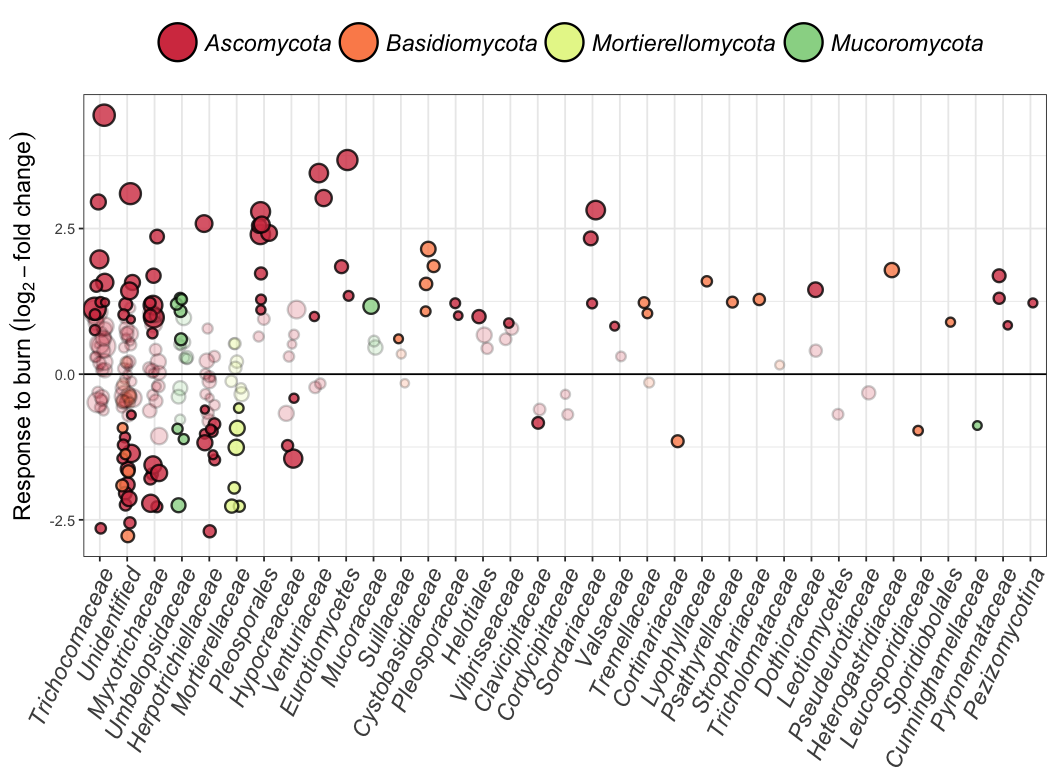

In [22]:
# Plotting data

options(repr.plot.width=8.8, repr.plot.height=6.5)

nTax=35

D = FullResults[FullResults$FixedFam %in% TaxOrder[1:nTax],]
D$AveExpr = D$AveExpr*100

p = ggplot(D,aes(x=FixedFam, y=logFC, alpha=sigSeverity, fill=Phylum))
#p = p + scale_fill_manual(values=c(wes_palette("Royal1")[1:4],wes_palette("Darjeeling"),wes_palette("GrandBudapest"),wes_palette("GrandBudapest")))
p = p + scale_fill_manual(values=c(brewer.pal(7,"Spectral")[c(1,2,5,6)]))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2)
p = p + scale_size(guide=FALSE)
p = p + scale_alpha_manual(guide=FALSE, values=c(0.2,0.8))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=65, hjust=1, size=14))
p = p + theme(axis.title.y = element_text(size=14))
p = p + theme(legend.position="top")
p = p + geom_hline(yintercept=0) 
p = p + ylab(expression(Response~to~burn~(log[2]-fold~change)))
p = p + theme(axis.text.x = element_text(face="italic"),
              legend.title = element_text(size=14),
             legend.text = element_text(size=14,face="italic"),
             axis.title.x = element_blank())
p = p + guides(fill=guide_legend(title="",override.aes = list(size=10)),alpha=FALSE)
p

In [23]:
# Pulling in the genera identified as being responsive to organic matter removal by Wilhelm et al. (2017)
# From the Long Term Soil Productivity studies

LTSP = c("Geoglossum","Gibberella","Preussia","Thelephora","Rhizoscyphus","Rhizosphaera","Mollisia",
        "Laccaria","Podospora","Hormonema","Talaromyces","Cryptococcus","Sagenomella","Cryptosporiopsis",
        "Venturia","Suillus","Tricholoma","Hygrophorus","Capronia","Cladophialophora","Mycena","Penicillium")

In [24]:
FullResults$LTSP = ""
FullResults$LTSP[FullResults$Genus %in% LTSP]="Yes"

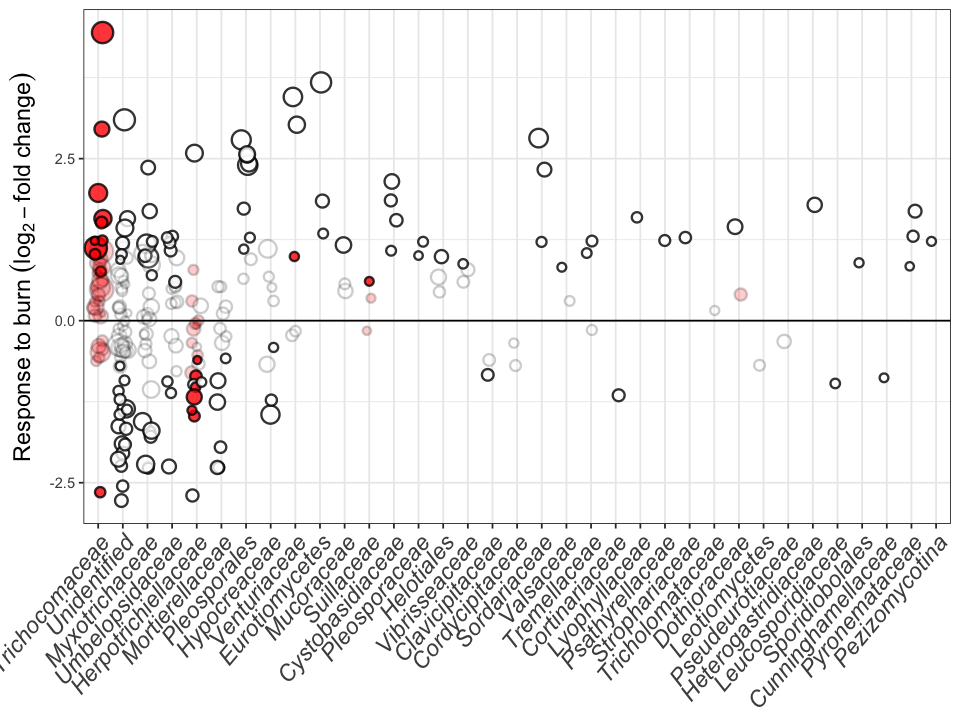

In [27]:
options(repr.plot.width=8, repr.plot.height=6)

p = ggplot(FullResults[FullResults$FixedFam %in% TaxOrder[1:nTax],],aes(x=FixedFam, y=logFC, alpha=sigSeverity, fill=LTSP))
p = p + geom_jitter(shape=21, stroke=1, aes(size=AveExpr), width=0.2)
p = p + scale_size(guide=FALSE)
p = p + scale_alpha_manual(guide=FALSE, values=c(0.2,0.8))
p = p + scale_fill_manual(values=c("white","red","white"))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=50, hjust=1, size=14))
p = p + theme(axis.title.y = element_text(size=14))
p = p + theme(legend.position="none")
p = p + geom_hline(yintercept=0) 
p = p + ylab(expression(Response~to~burn~(log[2]-fold~change)))
p = p + theme(axis.text.x = element_text(face="italic"),
             legend.text = element_text(face="italic"),
             axis.title.x = element_blank())
p

## Responsive taxa relative abundance distributions

In [34]:
# Finding relatively abundant taxa that are most strongly enriched in burned plots
Responders = results %>%
    group_by(OTU,logFC,sigSeverity,AveExpr)%>%
    summarize()%>%
    filter(sigSeverity == 1)%>%
    filter(logFC > 0)%>%
    filter(AveExpr>2)%>%
    arrange(-logFC)
TopResp = Responders[1:6,]$OTU
TopResp

[1] "sq4"  "sq9"  "sq24" "sq6"  "sq31" "sq65"

Warning message:
“Removed 144 rows containing non-finite values (stat_boxplot).”

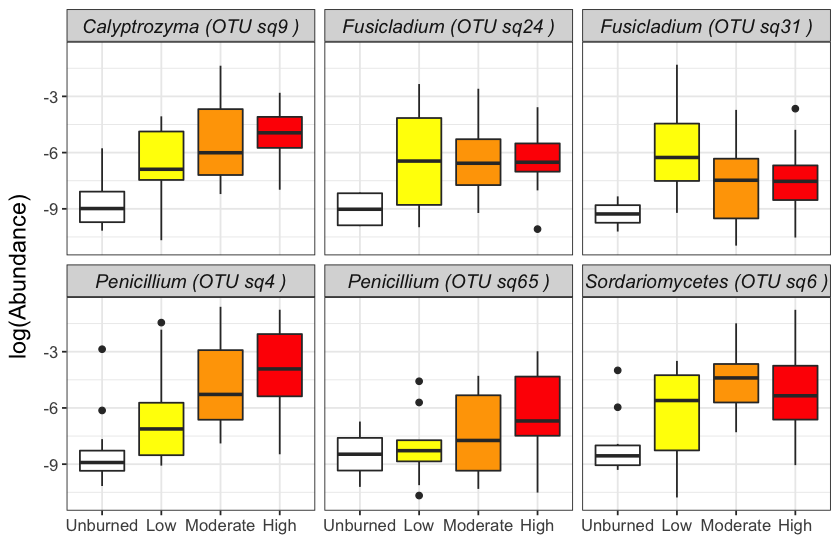

In [35]:
# Plotting the 6 strongest (and reasonably abundant) fire-responders

options(repr.plot.width=7, repr.plot.height=4.5)

d = mdf%>%
    filter(OTU %in% TopResp)%>%
    mutate(Namer = ifelse(Genus=="",paste(Class),paste(Genus)))%>%
    mutate(Name = paste(Namer,"(OTU",OTU,")"),sep="")

p = ggplot(d)
p = p + geom_boxplot(aes(Severity_Class, log(Abundance), fill=Severity_Class))
p = p + facet_wrap(~Name, ncol=3)
p = p + guides(color=FALSE, fill=FALSE)
p = p + scale_fill_manual(values=c("white","yellow","orange","red"))
p = p + theme_bw()
p = p + theme(strip.text.x = element_text(face="italic", size=11.5), 
              axis.title.x = element_blank(),
             axis.text.x = element_text(size=10),
             axis.text.y = element_text(size=10),
             axis.title.y = element_text(size=14))
p

In [31]:
# Running stats
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq9",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq24",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq31",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq4",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq65",])
summary(a)
a = aov(log(Abundance+1)~Burn_Severity_Index,d[d$OTU=="sq6",])
summary(a)

                    Df  Sum Sq  Mean Sq F value Pr(>F)
Burn_Severity_Index  1 0.00244 0.002444   2.117  0.149
Residuals           99 0.11430 0.001154               

                    Df   Sum Sq  Mean Sq F value  Pr(>F)   
Burn_Severity_Index  1 0.001481 0.001481   7.333 0.00798 **
Residuals           99 0.020000 0.000202                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    Df  Sum Sq   Mean Sq F value Pr(>F)
Burn_Severity_Index  1 0.00151 0.0015148   2.604   0.11
Residuals           99 0.05758 0.0005816               

                    Df Sum Sq Mean Sq F value  Pr(>F)   
Burn_Severity_Index  1 0.0613 0.06131   8.633 0.00411 **
Residuals           99 0.7031 0.00710                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    Df   Sum Sq   Mean Sq F value  Pr(>F)   
Burn_Severity_Index  1 0.000419 0.0004191   7.649 0.00678 **
Residuals           99 0.005425 0.0000548                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    Df Sum Sq  Mean Sq F value Pr(>F)
Burn_Severity_Index  1 0.0047 0.004668   1.437  0.234
Residuals           99 0.3216 0.003249               

In [36]:
# Considering the negative responders that are most abundant
Responders = results %>%
    group_by(OTU,logFC,sigSeverity,AveExpr)%>%
    summarize()%>%
    filter(sigSeverity == 1)%>%
    filter(logFC < -1)%>%
    arrange(-AveExpr)
TopResp = Responders[1:8,]$OTU
TopResp

[1] "sq23"  "sq41"  "sq22"  "sq47"  "sq35"  "sq122" "sq118" "sq80" 

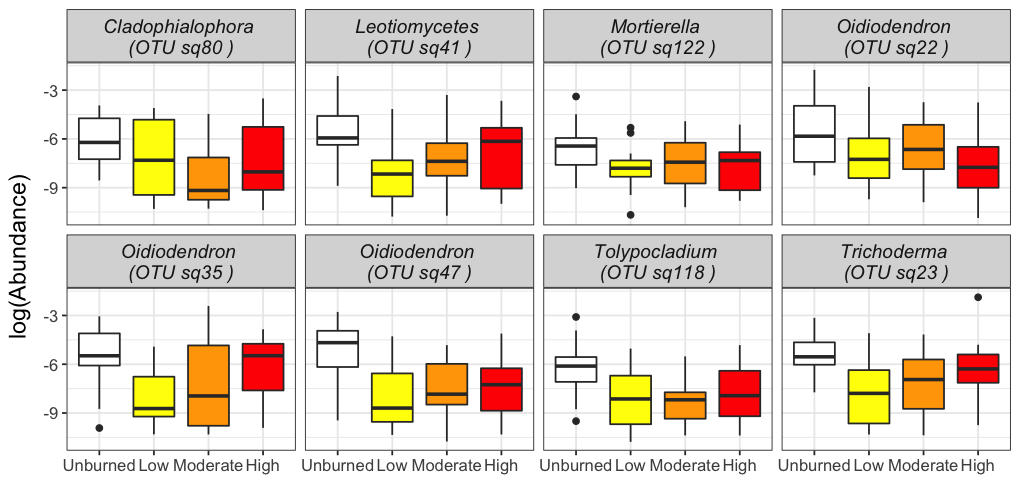

In [37]:
# Plotting negative responders

options(repr.plot.width=8.5, repr.plot.height=4)
d = mdf%>%
    filter(OTU %in% TopResp)%>%
    mutate(Namer = ifelse(Genus=="",paste(Class),paste(Genus)))%>%
    mutate(Name = paste(Namer,"\n(OTU",OTU,")"),sep="")%>%
    filter(Abundance>0)

p = ggplot(d)
p = p + geom_boxplot(aes(Severity_Class, log(Abundance), fill=Severity_Class))
p = p + facet_wrap(~Name, ncol=4)
p = p + guides(color=FALSE, fill=FALSE)
p = p + scale_fill_manual(values=c("white","yellow","orange","red"))
p = p + theme_bw()
p = p + theme(strip.text.x = element_text(face="italic", size=11.5), 
              axis.title.x = element_blank(),
             axis.text.x = element_text(size=10),
             axis.text.y = element_text(size=10),
             axis.title.y = element_text(size=14))
p